# Bert baseline for POLAR

## Introduction

In this part of the starter notebook, we will take you through the process of all three Subtasks.

## Subtask 1 - Polarization detection

This is a binary classification to determine whether a post contains polarized content (Polarized or Not Polarized).

In [ ]:
!unzip dev_phase.zip

Archive:  dev_phase.zip
replace subtask1/dev/nep.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# define file path
file_path = '/content/drive/MyDrive/NLP/'

In [ ]:
## Imports

In [ ]:
import pandas as pd


from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
from torch.utils.data import Dataset

!pip install nltk

import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [ ]:
# Load the training and validation data for subtask 1

train = pd.read_csv(file_path + 'subtask1/train/eng.csv')
val = pd.read_csv(file_path + 'subtask1/train/eng.csv')


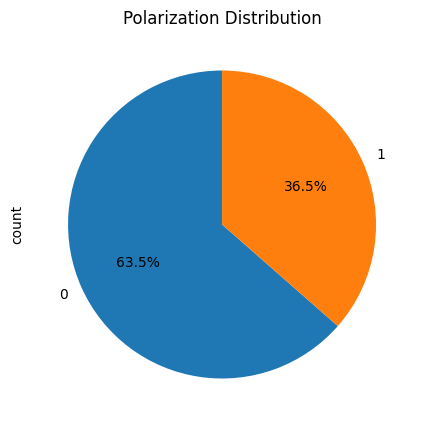

In [ ]:
# check polarization labels distribution
data['polarization'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(5, 5))
plt.title('Polarization Distribution')
plt.show()

In [ ]:
# sentiment analysis
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

classifier = pipeline(
    "sentiment-analysis",
    model=model_name,
    tokenizer=model_name
)


sentiments = train['text'].apply(lambda x: classifier(x)[0])

sentiment_labels = list()
sentiment_scores = list()

for sent in sentiments:
  sentiment_labels.append(sent['label'])
  sentiment_scores.append(sent['score'])

data = train.copy()

data['sentiment'] = sentiment_labels
data['score'] = sentiment_scores

data.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  polarization sentiment  \
0           is defending imperialism in the dnd chat             0  NEGATIVE   
1  Still playing with this. I am now following Ra...             0  POSITIVE   
2  .senate.gov Theres 3 groups out there Republic...             0  NEGATIVE   
3  "ABC MD, David Anderson, said the additional f...             0  NEGATIVE   
4  "bad people" I have some conservative values s...             0  NEGATIVE   

      score  
0  0.983461  
1  0.975958  
2  0.993120  
3  0.513509  
4  0.706923

In [ ]:
# Plot bigrams to show most frequesntly used pair of words

stop_words = set(stopwords.words("english"))

def extract_bigrams(data):

    bigram_list = []

    for text in data:

        # tokenize and lowercase
        tokens = nltk.word_tokenize(text.lower())

        # Remove stopwords + remove punctuation tokens
        filtered_tokens = [
            t for t in tokens
            if t.isalpha() and t not in stop_words
        ]

        bigrams_in_text = list(bigrams(filtered_tokens))
        bigram_list.extend(bigrams_in_text)

    bigram_counts = Counter(bigram_list)

    # Get the top 20 most frequent bigrams
    top_bigrams = bigram_counts.most_common(20)
    return top_bigrams


def plot_bigrams(bigrams_list):
    # Prepare data for plotting
    labels = [' '.join(b) for b, c in top_bigrams]
    counts = [c for b, c in top_bigrams]

    plt.figure(figsize=(10,6))
    plt.barh(labels, counts, color='skyblue', alpha=0.7)
    plt.xlabel("Frequency")
    plt.ylabel("Bigram")
    plt.title("Most Frequent Word Pairs (Bigrams) in Polarized Text Set")
    plt.gca().invert_yaxis()  # most frequent at the top
    return plt.show()


[(('human', 'shields'), 31), (('ethnic', 'cleansing'), 31), (('apartheid', 'state'), 27), (('red', 'states'), 24), (('joe', 'biden'), 22), (('woke', 'mob'), 20), (('border', 'security'), 19), (('election', 'interference'), 19), (('stolen', 'election'), 18), (('rigged', 'election'), 17), (('radical', 'left'), 17), (('kamala', 'harris'), 17), (('jewish', 'state'), 16), (('donald', 'trump'), 16), (('illegal', 'immigration'), 16), (('second', 'amendment'), 15), (('election', 'fraud'), 14), (('open', 'borders'), 14), (('voter', 'suppression'), 14), (('mike', 'pence'), 13)]


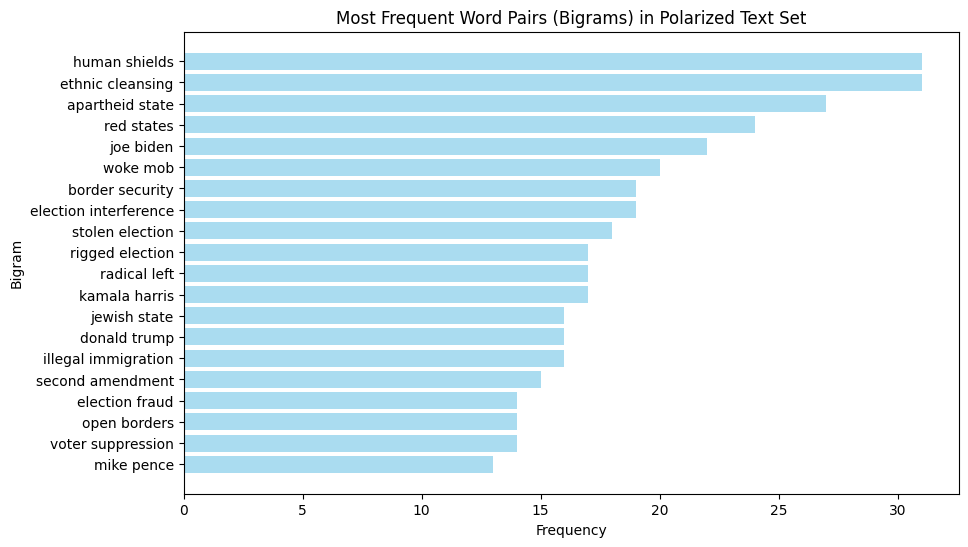

In [ ]:
# extract bigrams for polarized text
polarized_text = data[(data['polarization'] == 1) & (data['sentiment'] == 'NEGATIVE')]['text']
top_bigrams = extract_bigrams(polarized_text)

print(top_bigrams)
plot_bigrams(top_bigrams)

# Dataset
-  Create a pytorch class for handling data
-  Wrapping the raw texts and labels into a format that Huggingface’s Trainer can use for training and evaluation

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}
    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

Now, we'll tokenize the text data and create the datasets using `bert-base-uncased` as the tokenizer.

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = PolarizationDataset(train['text'].tolist(), train['polarization'].tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val['polarization'].tolist(), tokenizer)


Next, we'll load the pre-trained `bert-base-uncased` model for sequence classification. Since this is a binary classification task (Polarized/Not Polarized), we set `num_labels=2`.

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we'll define the training arguments and the evaluation metric. We'll use macro F1 score for evaluation.

In [ ]:
# Define metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
        output_dir=f"./",
        num_train_epochs=10,
        learning_rate=2e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        disable_tqdm=False
    )


Finally, we'll initialize the `Trainer` and start training.

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    data_collator=DataCollatorWithPadding(tokenizer) # Data collator for dynamic padding
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")

Macro F1 score on validation set: 0.7385787147228834


In [ ]:
# predict dev
dev = pd.read_csv(file_path + 'subtask1/dev/eng.csv')

# Create the dev dataset (dummy labels)
dev_dataset = PolarizationDataset(
    dev['text'].tolist(),
    labels=[0] * len(dev),
    tokenizer=tokenizer
)

# Predict
pred_output = trainer.predict(dev_dataset)
logits = pred_output.predictions

# Convert logits to predicted class labels
preds = np.argmax(logits, axis=1)

# Save predictions into the dataframe
dev['polarization'] = preds

dev.drop('text', axis=1, inplace=True)

# ! mkdir subtask_1

dev.to_csv('/content/subtask_1/pred_eng.csv', index=False)

!zip -r -q -o subtask_1.zip subtask_1

dev.head()

id  polarization
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0
2  eng_95770ff547ea5e48b0be00f385986483             0
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             0
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0

In [ ]:
# predictions results

dev['polarization'].value_counts()

polarization
0    108
1     52
Name: count, dtype: int64

# Subtask 2: Polarization Type Classification
Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

In [ ]:
train = pd.read_csv('subtask2/train/eng.csv')
val = pd.read_csv('subtask2/train/eng.csv')
train.head()

id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  political  \
0           is defending imperialism in the dnd chat          0   
1  Still playing with this. I am now following Ra...          0   
2  .senate.gov Theres 3 groups out there Republic...          0   
3  "ABC MD, David Anderson, said the additional f...          0   
4  "bad people" I have some conservative values s...          0   

   racial/ethnic  religious  gender/sexual  other  
0              0          0              0      0  
1              0          0              0      0  
2              0          0              0      0  
3              0          0              0      0  
4              0          0              0      0

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
dev_dataset = PolarizationDataset(val['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)


In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, problem_type="multi_label_classification") # 5 labels

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.
/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Macro F1 score on validation set for Subtask 2: 0.48596840937058694


# Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



In [ ]:
train = pd.read_csv('subtask3/train/eng.csv')
val = pd.read_csv('subtask3/train/eng.csv')

train.head()

id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  stereotype  \
0           is defending imperialism in the dnd chat           0   
1  Still playing with this. I am now following Ra...           0   
2  .senate.gov Theres 3 groups out there Republic...           0   
3  "ABC MD, David Anderson, said the additional f...           0   
4  "bad people" I have some conservative values s...           0   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             0               0                 0                0   
4             0               0                 0                0   

   invalidation  
0             0  
1             0  
2             0  
3             0  
4             0

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, problem_type="multi_label_classification") # use 6 labels

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.
/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/magguire/Desktop/NLP_LLMs/SemEval2026-task9/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Macro F1 score on validation set for Subtask 3: 0.5785201648301382
